In [1]:
from pathlib import Path

RCSB_DOWNLOAD_URL = "https://files.rcsb.org/download"

# change accordingly
metadata_path = Path("../data/RAS.csv")
raw_path = Path(f"../data/{metadata_path.stem}/raw")
pro_path = Path(f"../data/{metadata_path.stem}/processed")
fet_path = Path(f"../data/{metadata_path.stem}/featurized")

Download structures (*.PDB) from RCSB-PDB.

In [2]:
from tqdm import tqdm
import concurrent.futures
from urllib.error import HTTPError
from urllib import request
import pandas as pd
import os


def download(i):
    try:
        fn = f"{i}.pdb"
        request.urlretrieve(f"{RCSB_DOWNLOAD_URL}/{fn}", str(raw_path / fn))
        return True
    except HTTPError:
        return False


if not os.path.exists(raw_path):
    print(f"Downloading complexes structures from RCSB-PDB. ({metadata_path})")
    os.makedirs(raw_path)
    struct_ids = set(pd.read_csv(metadata_path)["Entry ID"].values)

    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        results = list(tqdm(executor.map(download, struct_ids), total=len(struct_ids), desc="Downloading..."))
        print(f"{results.count(False)} failed.")

In [3]:
from src.io import read_pdb, get_chain, save_chain

if not os.path.exists(str(pro_path)):
    print("Pre-processing structures.")
    os.makedirs(pro_path)
    metadata = pd.read_csv(metadata_path).groupby('Entry ID')['Auth Asym ID'].apply(list).to_dict()
    for pdb in tqdm(raw_path.glob('*.pdb')):
        pdb_id = pdb.stem
        pdb = read_pdb(pdb, sid=pdb_id)
        for chain_id in metadata[pdb_id]:
            cid = f"{pdb_id}_{chain_id}"
            chain = get_chain(pdb, chain_id)
            save_chain(f"{str(pro_path)}/{cid}.pdb", chain, cid)

```
python data/process_pdb_files.py --pdb_dir data/BLDB/processed --write_dir data/BLDB/featurized
```

In [4]:
with open(f"{fet_path}/cluster.txt", 'w', encoding='utf-8') as file:
    for item in [f"{path.stem}_1" for path in list(raw_path.glob('*.pdb'))]:
        file.write(item + '\n')

In [3]:
import src.colorscheme as color
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

metadata = pd.read_csv(metadata_path)
lengths = []
categories = []
entry_ids = []
for pdb in pro_path.glob('*.pdb'):
    pdb, chain_id = pdb.stem.split("_")
    if not (query := metadata[(metadata["Entry ID"] == pdb) & (metadata["Auth Asym ID"] == chain_id)]).empty:
        lengths.append(query["Polymer Entity Sequence Length"].values[0])
        categories.append(query["Macromolecule Name"].values[0])
        entry_ids.append(query["Entry ID"].values[0])

print(f"Count: Chain={len(metadata)} PDB={len(metadata['Entry ID'].unique())}")
print(f"Length: Median={np.median(lengths)}, mean={np.mean(lengths)}")

Count: Chain=895 PDB=511
Length: Median=170.0, mean=171.77064220183487


In [4]:
sampled_ref_ids = [entry_ids[i] for i in np.random.choice(range(len(lengths)), size=100, replace=False)]
sampled_ref = metadata[metadata["Entry ID"].isin(sampled_ref_ids)]
sampled_ref = sampled_ref.drop_duplicates(subset="Entry ID")
sampled_ref.to_csv(f"../data/{metadata_path.stem}_ref.csv", index=False)

In [45]:
sampled_lengths = np.array(lengths)[np.random.choice(len(lengths), 50, replace=False)]
pd.DataFrame({
    "sample": range(len(sampled_lengths)),
    "length": np.sort(sampled_lengths),
}).to_csv(f"../data/{metadata_path.stem}_gen.csv", index=False)

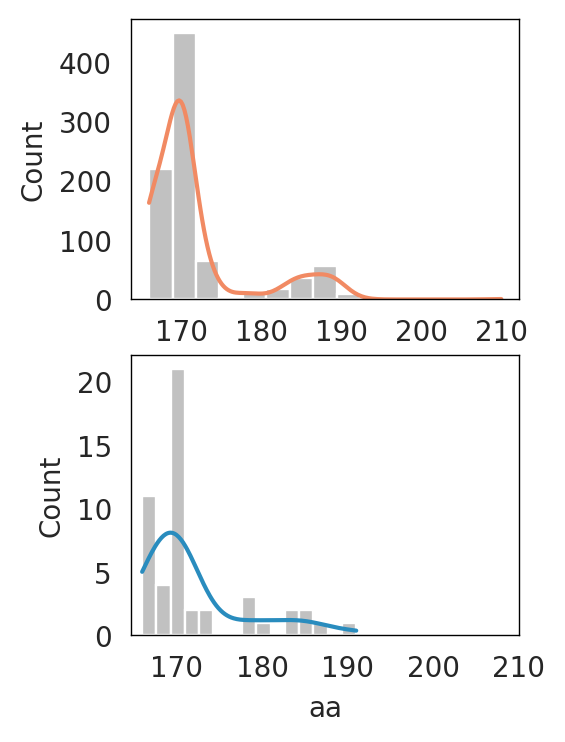

In [47]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(2.5, 4), dpi=200)
sns.histplot(pd.Series(lengths).astype(float), kde=True, stat="count", bins=15, color=color.CS_BG, ax=ax1)
ax1.lines[0].set_color(color.CS_FG_A)
sns.histplot(pd.Series(sampled_lengths).astype(float), kde=True, stat="count", bins=15, color=color.CS_BG, ax=ax2)
ax2.lines[0].set_color(color.CS_FG_B)

plt.grid(which="major", axis="both", color="black", alpha=0.1)
for spine in list(ax1.spines.values()) + list(ax2.spines.values()):
    spine.set_edgecolor("k")
    spine.set_linewidth(0.5)

# ax1.set_xticks([250, 300, 350, 400]); ax2.set_xticks([250, 300, 350, 400])
# ax1.set_xticks([100, 200, 300, 400, 500]); ax2.set_xticks([100, 200, 300, 400, 500])
# ax1.set_xticks([100, 200, 300, 400]); ax2.set_xticks([100, 200, 300, 400])
ax1.set_xticks([170, 180, 190, 200, 210]); ax2.set_xticks([170, 180, 190, 200, 210])
# # plt.title(metadata_path.stem)
plt.xlabel('aa')
ax1.grid(False)
ax2.grid(False)
plt.show()

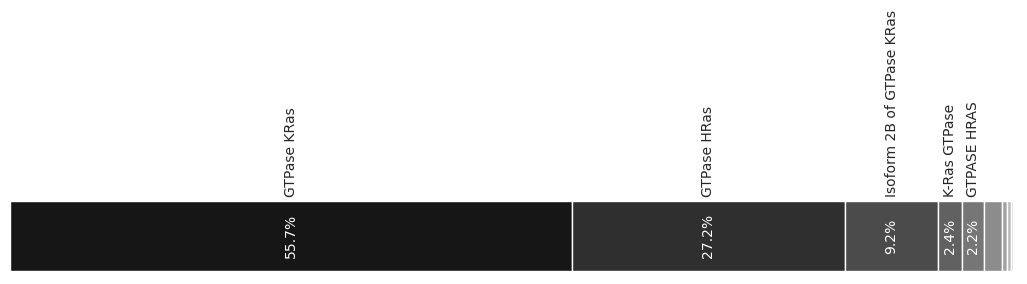

In [5]:
from collections import Counter

category_counts = Counter(categories)
total = sum(category_counts.values())
proportions = {k: v / total * 100 for k, v in category_counts.items()}
sorted_proportions = dict(sorted(proportions.items(), key=lambda item: item[1], reverse=True))
labels = list(sorted_proportions.keys())
values = list(sorted_proportions.values())
plt.figure(figsize=(13, 1))
cmap = plt.cm.Greys
colors = [cmap(i / len(values)) for i in range(len(values))][::-1]


def wrap_labels(label, max_width):
    words = label.split()
    wrapped_label = ""
    line = ""
    for word in words:
        if len(line + " " + word) <= max_width:
            line += " " + word
        else:
            wrapped_label += line + "\n"
            line = word
    wrapped_label += line
    return wrapped_label.strip()


max_width = 30
for i, (label, value) in enumerate(sorted_proportions.items()):
    plt.barh(0, value, left=sum(values[:i]), color=colors[i], edgecolor='white')
    if value >= 2:
        wrapped_label = wrap_labels(label, max_width)
        plt.text(sum(values[:i]) + value / 2, 0.45,
                 wrapped_label, ha='center', va='bottom', fontsize=10, rotation=90)
    if value >= 2:
        plt.text(sum(values[:i]) + value / 2, 0,
                 f'{value:.1f}%', ha='center', va='center', color='white', fontsize=10, rotation=90)

plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xlim(0, 100)
plt.gca().axes.get_yaxis().set_ticks([])
plt.gca().axes.get_xaxis().set_ticks([])
plt.show()

```
python runner/train.py
python runner/inference.py
```